In [122]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx
from sklearn.datasets.samples_generator import make_blobs

# 1.谱聚类

In [111]:
##谱聚类
#计算欧氏距离
def euclidDistance(x1, x2, sqrt_flag = True):
    res = np.sum((x1-x2)**2)
    if sqrt_flag:
        res = np.sqrt(res)
    return res

#距离矩阵
def calEuclidDistanceMatrix(X):
    X = np.array(X)
    S = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            S[i][j] = 1.0 * euclidDistance(X[i], X[j])
            S[j][i] = S[i][j]
    return S

#邻接矩阵(相似度矩阵)
def myKNN(S, k, sigma=1.0):
    N = len(S)
    A = np.zeros((N,N))

    for i in range(N):
        dist_with_index = zip(S[i], range(N))
        dist_with_index = sorted(dist_with_index, key = lambda x:x[0])
        neighbours_id = [dist_with_index[m][1] for m in range(k+1)] # xi's k nearest neighbours
        
        for j in neighbours_id: # xj is xi's neighbour
            A[i][j] = np.exp(-S[i][j]/2/sigma/sigma)
            A[j][i] = A[i][j] # mutually
    return A

#归一化的对称拉普拉斯矩阵
def calLaplacianMatrix(adjacentMatrix):
    # compute the Degree Matrix: D=sum(A)
    degreeMatrix = np.sum(adjacentMatrix, axis=1)
    # compute the Laplacian Matrix: L=D-A
    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix
    # normailze
    # D^(-1/2) L D^(-1/2)
    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
    return np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)



#导入数据集

iris = datasets.load_iris()
X = iris.data
y = iris.target


#求距离矩阵
S = calEuclidDistanceMatrix(X)
#print(S)
#print(S.shape)

#求邻接矩阵
A = myKNN(S, 149, sigma=0.8)


#求拉普拉斯矩阵
Laplacian = calLaplacianMatrix(A)
#print(Laplacian)
#print(Laplacian.shape)

#特征值分解
lam, H = np.linalg.eig(Laplacian) # H'shape is n*n


#选择前三个最大的特征值
inds = np.argsort(lam)[:3]

#特征值对应的特征向量
Vectors = H[:, inds]

#特征向量标准化
normalizer = np.linalg.norm(Vectors, axis=1)
normalizer = np.repeat(np.transpose([normalizer]), 3, axis=1)
Vectors = Vectors / normalizer
#print(H)
#print(H.shape)
#print(lam)
#print(lam.shape)

# 2.将鸢尾花数据集画成图的形式

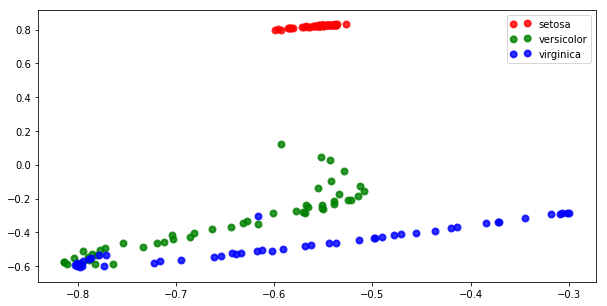

In [112]:
X = Vectors   #谱聚类后的样本特征
y = y     #样本类别
target_names = iris.target_names  #类别名称

plt.subplots(figsize=(10,5))
colors = ['r', 'g', 'b']
lw = 2

#可视化.将有关数组打包成元组列表；依次获取列表元素
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X[y == i, 0], X[y == i, 1], color = color, alpha =0.8, lw = lw, label = target_name)
#设定图例在合适位置；指定散点图例的标记点数
plt.legend(loc='best', shadow=False, scatterpoints=2)

# 3.根据邻接矩阵进行聚类

In [117]:
#K-means聚类

def dist_eclud(vecA, vecB):
    vec_square = []
    for element in vecA - vecB:#两个向量中的每个元素相减
        element = element ** 2#得到的差差平方
        vec_square.append(element)
    return sum(vec_square) ** 0.5#相加再开根号得到欧式距离

def rand_cent(data_set, k):
    n = data_set.shape[1]#数据维度
    centroids = np.zeros((k, n))#创建0矩阵
    for j in range(n):
        min_j = float(min(data_set[:,j]))#所有数据某一维度的最小值
        range_j = float(max(data_set[:,j])) - min_j#所有数据在这一维度的变化范围
        centroids[:,j] = (min_j + range_j * np.random.rand(k, 1))[:,0]#在该范围内随机确定质心位置
    return centroids

def Kmeans(data_set, k):#输入数据集和要分成的簇的数量
    m = data_set.shape[0]#数据点的数量
    cluster_assment = np.zeros((m, 2))#创建m行2列的0矩阵，两列分别存储每个点所属的簇和该点距离所属质心的距离(即误差)，矩阵中各点
                                          #初始值均为0，在下面的循环中更新数值
    centroids = rand_cent(data_set, k)#创建随机初始质心
    cluster_changed = True
    while cluster_changed:#如果cluster_changed为True，循环执行
        cluster_changed = False#如果所有的数据点归属都不再变化，while循环结束
        for i in range(m):#对于数据集中的每个点
            min_dist = np.inf;
            min_index = -1#np.inf表示正无穷，min_dist表示误差，即数据点与质心的距离，min_index表示每个点所属的簇，初始化为-1
            for j in range(k):#对于k个现有质心分别计算数据点到这几个质心的距离并确定归属哪个簇
                dist_ji = dist_eclud(centroids[j,:], data_set[i,:])#计算距离
                if dist_ji < min_dist:#min_dist初始值为正无穷，第一次执行该循环(即j=0)，小于号一定成立，于是该数据点属于第一个簇，
                                    #然后更新min_dist为该数据点与第一个质心的距离，再计算该数据点与第二个质心的距离(j=1)并比较
                    min_dist = dist_ji;
                    min_index = j#更新点属于哪个簇
            if cluster_assment[i,0] != min_index:
                cluster_changed = True#只要有一个数据点与上一次的分组结果不同，cluster_changed就为True，while循环继续执行
            cluster_assment[i,:] = min_index, min_dist**2#cluster_assment矩阵的第i行数据更新为min_index,min_dist**2
        for cent in range(k):
            pts_inclust = data_set[np.nonzero(list(map(lambda x:x == cent, cluster_assment[:,0])))]#获取第cent+1个簇中所有
                                                                                               #的数据点，存储到pts_inclust中
            centroids[cent,:] = np.mean(pts_inclust, axis=0)#计算质心坐标，axis=0表示按pts_inclust的列方向计算均值
    return centroids, cluster_assment

data_set = Vectors
my_centroids, my_cluster_assment = Kmeans(data_set, 3)    #给Kmeans函数传递参数，返回质心点和分簇结果



# 4.聚类结果可视化

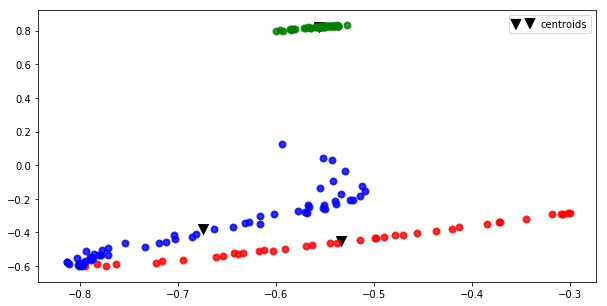

In [118]:
colors = ['r', 'g', 'b']

cent_x = my_centroids[:,0]
cent_y = my_centroids[:,1]

fig, ax = plt.subplots(figsize=(10,5))#画图
ax.scatter(cent_x, cent_y, s=100, c="black", marker="v", label="centroids")

for color, i, in zip(colors, [0, 1, 2]):
    plt.scatter(data_set[my_cluster_assment[: ,0] == i, 0], data_set[my_cluster_assment[: ,0] == i, 1], color = color,
                alpha =0.8, lw = lw)

#设定图例在合适位置；指定散点图例的标记点数
plt.legend(loc='best', shadow=False, scatterpoints=2)
plt.show()#显示图

# 5.转换成图

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


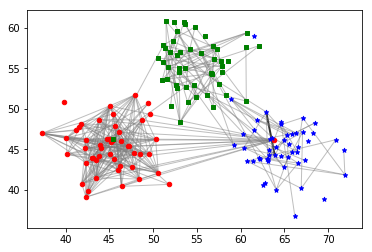

In [119]:
#利用make_blobs生成三个簇
X, y = make_blobs(n_samples=150, centers=[(45,45),(55,55),(65,45)], n_features=2,cluster_std=[3.0,3.0,3.0],random_state=0,shuffle=False)
x = np.array(X)

#字典存储点的坐标
pos={}
for i in range(150):
    pos[i]=x[i-1]

            
##根据邻接矩阵画图
G = nx.Graph()  #创建一个空图

#添加点
for i in range(150):
    G.add_node(i)
    
#添加边
for i in range(150):
    for j in range(i, 150):
        if A[i][j] > 0.75:
            G.add_edge(i, j, weight = A[i][j])
            
node0 = [i for i in range(50)]
node1 = [i for i in range(50, 100)]
node2 = [i for i in range(100, 150)]

#设置边的属性
edge1 = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 0.95]
edge2 = [(u, v) for (u, v, d) in G.edges(data=True) if (d['weight'] < 0.95) & (d['weight'] > 0.7)]
edge3 = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.7]

#绘制点
nx.draw_networkx_nodes(G, pos, node_size = 20, nodelist = node0, node_color = 'r', node_shape = 'o')
nx.draw_networkx_nodes(G, pos, node_size = 20, nodelist = node1, node_color = 'g', node_shape = 's')
nx.draw_networkx_nodes(G, pos, node_size = 20, nodelist = node2, node_color = 'b', node_shape = '*')

#绘制边
nx.draw_networkx_edges(G, pos, edgelist=edge1, width=2, alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=edge2, width=1, alpha=0.5, edge_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=edge3, width=1, alpha=0.5, edge_color='gray', style='dashed')
plt.show()

# 6.求分簇正确率

In [120]:
##求分簇正确率

cluster = my_cluster_assment[:, 0]
cluster = cluster.astype(int)

#返回第0、 1、 2簇的数据下标
cluster0 = []
cluster1 = []
cluster2 = []

for i in range(150):
    if cluster[i] == 0:
        cluster0.append(i)
    elif cluster[i] == 1:
        cluster1.append(i)
    else:
        cluster2.append(i)

#每一簇的每一个数据对应的真实类别
lab0 = []
lab1 = []
lab2 = []
for i in range(len(cluster0)):
    lab0.append(y[cluster0[i]])
#print(lab0)

for i in range(len(cluster1)):
    lab1.append(y[cluster1[i]])
#print(lab1)

for i in range(len(cluster2)):
    lab2.append(y[cluster2[i]])
#print(lab2)

#寻找每一个簇中最多的真实类别

def maxlist(lt):
    index = 0                       #记录出现次数最多的元素下标
    mmax = 0                          #记录最大的元素出现次数
    for i in range(len(lt)):
        flag = 0                    #记录每一个元素出现的次数
        for j in range(i+1,len(lt)): #遍历i之后的元素下标
            if lt[j] == lt[i]:
                flag += 1           #每当发现与自己相同的元素，flag+1
        if flag > mmax:              #如果此时元素出现的次数大于最大值，记录此时元素的下标
            mmax = flag
            index1 = i
    return lt[index1]               #返回出现最多的元素

#每一个簇代表的类别
c0 = maxlist(lab0)
c1 = maxlist(lab1)
c2 = maxlist(lab2)

#计算分簇正确率
acc = 0
for i in range(len(cluster0)):
    if lab0[i] == c0:
        acc += 1
for i in range(len(cluster1)):
    if lab1[i] == c1:
        acc += 1
        
for i in range(len(cluster2)):
    if lab2[i] == c2:
        acc += 1

#print(c0, c1, c2)
print('%.2f%%'%(acc/150*100))

90.00%


In [ ]:
##谱聚类
#计算欧氏距离
def euclidDistance(x1, x2, sqrt_flag = True):
    res = np.sum((x1-x2)**2)
    if sqrt_flag:
        res = np.sqrt(res)
    return res

#距离矩阵
def calEuclidDistanceMatrix(X):
    X = np.array(X)
    S = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            S[i][j] = 1.0 * euclidDistance(X[i], X[j])
            S[j][i] = S[i][j]
    return S

#邻接矩阵(相似度矩阵)
def myKNN(S, k, sigma=1.0):
    N = len(S)
    A = np.zeros((N,N))

    for i in range(N):
        dist_with_index = zip(S[i], range(N))
        dist_with_index = sorted(dist_with_index, key = lambda x:x[0])
        neighbours_id = [dist_with_index[m][1] for m in range(k+1)] # xi's k nearest neighbours
        
        for j in neighbours_id: # xj is xi's neighbour
            A[i][j] = np.exp(-S[i][j]/2/sigma/sigma)
            A[j][i] = A[i][j] # mutually
    return A

#标准化的拉普拉斯矩阵
def calLaplacianMatrix(adjacentMatrix):
    # compute the Degree Matrix: D=sum(A)
    degreeMatrix = np.sum(adjacentMatrix, axis=1)
    # compute the Laplacian Matrix: L=D-A
    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix
    # normailze
    # D^(-1/2) L D^(-1/2)
    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
    return np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)



#导入数据集

iris = datasets.load_iris()
X = iris.data
y = iris.target


#求距离矩阵
S = calEuclidDistanceMatrix(X)
#print(S)
#print(S.shape)

#求邻接矩阵
A = myKNN(S, 149, sigma=1.0)


#求拉普拉斯矩阵
Laplacian = calLaplacianMatrix(A)
#print(Laplacian)
#print(Laplacian.shape)

#特征值分解
lam, H = np.linalg.eig(Laplacian) # H'shape is n*n


#选择前三个最大的特征值
inds = np.argsort(lam)[:5]

#特征值对应的特征向量
Vectors = H[:, inds]

#特征向量标准化
normalizer = np.linalg.norm(Vectors, axis=1)
normalizer = np.repeat(np.transpose([normalizer]), 5, axis=1)
Vectors = Vectors / normalizer
#print(H)
#print(H.shape)
#print(lam)
#print(lam.shape)


##1.将鸢尾花数据集画成图的形式

X = Vectors   #谱聚类后的样本特征
y = y     #样本类别
target_names = iris.target_names  #类别名称

plt.subplots(figsize=(10,5))
colors = ['r', 'g', 'b']
lw = 2

#可视化.将有关数组打包成元组列表；依次获取列表元素
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X[y == i, 0], X[y == i, 1], color = color, alpha =0.8, lw = lw, label = target_name)
#设定图例在合适位置；指定散点图例的标记点数
plt.legend(loc='best', shadow=False, scatterpoints=2)


##
#K-means聚类

def dist_eclud(vecA, vecB):
    vec_square = []
    for element in vecA - vecB:#两个向量中的每个元素相减
        element = element ** 2#得到的差差平方
        vec_square.append(element)
    return sum(vec_square) ** 0.5#相加再开根号得到欧式距离

def rand_cent(data_set, k):
    n = data_set.shape[1]#数据维度
    centroids = np.zeros((k, n))#创建0矩阵
    for j in range(n):
        min_j = float(min(data_set[:,j]))#所有数据某一维度的最小值
        range_j = float(max(data_set[:,j])) - min_j#所有数据在这一维度的变化范围
        centroids[:,j] = (min_j + range_j * np.random.rand(k, 1))[:,0]#在该范围内随机确定质心位置
    return centroids

def Kmeans(data_set, k):#输入数据集和要分成的簇的数量
    m = data_set.shape[0]#数据点的数量
    cluster_assment = np.zeros((m, 2))#创建m行2列的0矩阵，两列分别存储每个点所属的簇和该点距离所属质心的距离(即误差)，矩阵中各点
                                          #初始值均为0，在下面的循环中更新数值
    centroids = rand_cent(data_set, k)#创建随机初始质心
    cluster_changed = True
    while cluster_changed:#如果cluster_changed为True，循环执行
        cluster_changed = False#如果所有的数据点归属都不再变化，while循环结束
        for i in range(m):#对于数据集中的每个点
            min_dist = np.inf;
            min_index = -1#np.inf表示正无穷，min_dist表示误差，即数据点与质心的距离，min_index表示每个点所属的簇，初始化为-1
            for j in range(k):#对于k个现有质心分别计算数据点到这几个质心的距离并确定归属哪个簇
                dist_ji = dist_eclud(centroids[j,:], data_set[i,:])#计算距离
                if dist_ji < min_dist:#min_dist初始值为正无穷，第一次执行该循环(即j=0)，小于号一定成立，于是该数据点属于第一个簇，
                                    #然后更新min_dist为该数据点与第一个质心的距离，再计算该数据点与第二个质心的距离(j=1)并比较
                    min_dist = dist_ji;
                    min_index = j#更新点属于哪个簇
            if cluster_assment[i,0] != min_index:
                cluster_changed = True#只要有一个数据点与上一次的分组结果不同，cluster_changed就为True，while循环继续执行
            cluster_assment[i,:] = min_index, min_dist**2#cluster_assment矩阵的第i行数据更新为min_index,min_dist**2
        for cent in range(k):
            pts_inclust = data_set[np.nonzero(list(map(lambda x:x == cent, cluster_assment[:,0])))]#获取第cent+1个簇中所有
                                                                                               #的数据点，存储到pts_inclust中
            centroids[cent,:] = np.mean(pts_inclust, axis=0)#计算质心坐标，axis=0表示按pts_inclust的列方向计算均值
    return centroids, cluster_assment

data_set = Vectors
my_centroids, my_cluster_assment = Kmeans(data_set, 3)    #给Kmeans函数传递参数，返回质心点和分簇结果



colors = ['r', 'g', 'b']

cent_x = my_centroids[:,0]
cent_y = my_centroids[:,1]

fig, ax = plt.subplots(figsize=(10,5))#画图
ax.scatter(cent_x, cent_y, s=100, c="black", marker="v", label="centroids")

for color, i, in zip(colors, [0, 1, 2]):
    plt.scatter(data_set[my_cluster_assment[: ,0] == i, 0], data_set[my_cluster_assment[: ,0] == i, 1], color = color,
                alpha =0.8, lw = lw)

#设定图例在合适位置；指定散点图例的标记点数
plt.legend(loc='best', shadow=False, scatterpoints=2)
plt.show()#显示图


##聚类结果可视化

#利用make_blobs生成三个簇
X, y = make_blobs(n_samples=150, centers=[(45,45),(55,55),(65,45)], n_features=2,cluster_std=[3.0,3.0,3.0],random_state=0,shuffle=False)
x = np.array(X)

#字典存储点的坐标
pos={}
for i in range(150):
    pos[i]=x[i-1]

            
##根据邻接矩阵画图
G = nx.Graph()  #创建一个空图

#添加点
for i in range(150):
    G.add_node(i)
    
#添加边
for i in range(150):
    for j in range(i, 150):
        if A[i][j] > 0.8:
            G.add_edge(i, j, weight = A[i][j])
            
node0 = [i for i in range(50)]
node1 = [i for i in range(50, 100)]
node2 = [i for i in range(100, 150)]

#设置边的属性
edge1 = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 0.95]
edge2 = [(u, v) for (u, v, d) in G.edges(data=True) if (d['weight'] < 0.95) & (d['weight'] > 0.7)]
edge3 = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.7]

#绘制点
nx.draw_networkx_nodes(G, pos, node_size = 20, nodelist = node0, node_color = 'r', node_shape = 'o')
nx.draw_networkx_nodes(G, pos, node_size = 20, nodelist = node1, node_color = 'g', node_shape = 's')
nx.draw_networkx_nodes(G, pos, node_size = 20, nodelist = node2, node_color = 'b', node_shape = '*')

#绘制边
nx.draw_networkx_edges(G, pos, edgelist=edge1, width=2, alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=edge2, width=1, alpha=0.5, edge_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=edge3, width=1, alpha=0.5, edge_color='gray', style='dashed')
plt.show()


##求分簇正确率

cluster = my_cluster_assment[:, 0]
cluster = cluster.astype(int)

#返回第0、 1、 2簇的数据下标
cluster0 = []
cluster1 = []
cluster2 = []

for i in range(150):
    if cluster[i] == 0:
        cluster0.append(i)
    elif cluster[i] == 1:
        cluster1.append(i)
    else:
        cluster2.append(i)

#每一簇的每一个数据对应的真实类别
lab0 = []
lab1 = []
lab2 = []
for i in range(len(cluster0)):
    lab0.append(y[cluster0[i]])
#print(lab0)

for i in range(len(cluster1)):
    lab1.append(y[cluster1[i]])
#print(lab1)

for i in range(len(cluster2)):
    lab2.append(y[cluster2[i]])
#print(lab2)

#寻找每一个簇中最多的真实类别

def maxlist(lt):
    index = 0                       #记录出现次数最多的元素下标
    mmax = 0                          #记录最大的元素出现次数
    for i in range(len(lt)):
        flag = 0                    #记录每一个元素出现的次数
        for j in range(i+1,len(lt)): #遍历i之后的元素下标
            if lt[j] == lt[i]:
                flag += 1           #每当发现与自己相同的元素，flag+1
        if flag > mmax:              #如果此时元素出现的次数大于最大值，记录此时元素的下标
            mmax = flag
            index1 = i
    return lt[index1]               #返回出现最多的元素

#每一个簇代表的类别
c0 = maxlist(lab0)
c1 = maxlist(lab1)
c2 = maxlist(lab2)

#计算分簇正确率
acc = 0
for i in range(len(cluster0)):
    if lab0[i] == c0:
        acc += 1
for i in range(len(cluster1)):
    if lab1[i] == c1:
        acc += 1
        
for i in range(len(cluster2)):
    if lab2[i] == c2:
        acc += 1

#print(c0, c1, c2)
print(acc/150)